# Studying wikipedia page importance with Directional Networks


Wikipedia is a free open-collaborative encyclopedia created and maintained by a community of volunteer contributors. 

Inside each wikipedia page there is an in-depth description of the topic, with multiple references to other topics mentioned along the text.

This study focuses on wikipedia pages about people and how the different pages reference each other.

A json composed of **1.259.797** different people who have an article written on the english wikipedia is used. Each person in this JSON has a list with all the other people that they mention.

This data is studied using a Directional Network that keeps track of the direction of the references.

The aim of the project is to answer the following questions:

1. How are the articles connected? Do the articles normally reference people born before, after or in the same period of the subject of the page?
2. Which are the most referenced people? Which are the people most essential to linking different pages together?

## 1. The data

The data is available on https://www.kaggle.com/simonburton/wikipedia-people-network.

It contains information about **1.259.797** people born from 1830 to 2003.
The features included are:

* 'birth_year': The year of birth of this person.
* 'link': Which are the people it references.

## 2. Data processing

Additionally to the available data, tree new features were created: 

* 'number_mentions': The number of times the person is referenced by the others.
* 'referenced_pages': The number of different pages referenced by the person.
* 'year_difference_vector': An array which contains the difference between the birth year of the person and the birth year of each page it references.

The processed data is shown below.

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import json
import matplotlib
from urllib.parse import unquote
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.display import Markdown as md
from collections import Counter
import operator
pd.set_option('display.max_rows', 100)


In [2]:
#reading json file
wikipedia_df = pd.read_json('./input/input.json')

#Creating the year of birth variable
wikipedia_df['birth_year']=wikipedia_df['dob'].apply(lambda x:x[0])
wikipedia_df.drop(['dob'],axis=1,inplace=True)

#Creating the referenced_pages - the total number of other people the page references
wikipedia_df['referenced_pages']=wikipedia_df['links'].apply(lambda x:len(x))

#Counting the number of times each person is mentioned by other pages
counts_per_person={}
total_connections=0
for index, row in wikipedia_df.T.iteritems():
    for linked_name in row['links']:
        total_connections+=1
        if linked_name in counts_per_person:
            counts_per_person[linked_name]+=1
        else:
            counts_per_person[linked_name]=int(1)
mentions=pd.DataFrame(list(zip(counts_per_person.keys(),counts_per_person.values())),columns=['name','number_mentions'])

#Unifying all variables in a single table
wikipedia_unified=wikipedia_df.merge(mentions,on='name',how='outer')

#Creating list with difference between birth date of person and birth date of each of its references
dict_years=dict(zip(wikipedia_df['name'],wikipedia_df['birth_year']))

def calculate_difference_vector(x):
    list_birth_years=[dict_years[name] for name in x['links']]
    return x['birth_year']*np.ones(len(list_birth_years))-list_birth_years

wikipedia_unified['year_difference_vector']=wikipedia_unified.apply(lambda x:calculate_difference_vector(x),axis=1)

#Showing top 5 most mentioned people
wikipedia_unified.set_index('name').sort_values('number_mentions',ascending=False).head(5)

links  birth_year  \
name                                                                            
Barack_Obama    [Alan_Keyes, Alexi_Giannoulias, Alice_Palmer_(...        1961   
George_W._Bush  [Adam_McKay, Al_Gore, Alan_Greenspan, Alan_Key...        1946   
Bill_Clinton    [Al_Gore, Ann_Claire_Williams, Barack_Obama, B...        1946   
Ronald_Reagan   [Aaron_Mitchell_(murderer), Alan_Greenspan, Al...        1911   
Donald_Trump    [Abdel_Fattah_el-Sisi, Abu_Bakr_al-Baghdadi, A...        1946   

                referenced_pages  number_mentions  \
name                                                
Barack_Obama                  98           5472.0   
George_W._Bush               122           4365.0   
Bill_Clinton                 109           3768.0   
Ronald_Reagan                122           3583.0   
Donald_Trump                 117           3378.0   

                                           year_difference_vector  
name                                                               
Barack_Obama    [11.0, -15.0, 22.0, 7.0, 19.0, 2.0, -10.0, 5.0...  
George_W._Bush  [-22.0, -2.0, 20.0, -4.0, -9.0, 18.0, -5.0, -1...  
Bill_Clinton    [-2.0, -3.0, -15.0, 23.0, 3.0, 15.0, 13.0, 74....  
Ronald_Reagan   [-19.0, -15.0, 24.0, -25.0, -25.0, -36.0, -29....  
Donald_Trump    [-8.0, -25.0, -2.0, -12.0, -25.0, -11.0, -7.0,...

## 3. Network overview

Before moving into a more detailed analysis, it is interesting to understand the general behavior of the network.

Each page in the network has an in-Degree value, which is the number of people that referenced this person ('number_mentions').

The fraction of people in each "number_mentions" value was calculated and is shown below. Each blue dot represents the fraction of nodes that have a given number of mentions.

As expected of a network, most nodes have a low number of mentions, while a minority is mentioned multiple times. This follows a power law with equation $P(k)=200k^{-2}$.

The red curve shows the cumulative fraction, which shows:
* **35%** of nodes have an In-Degree value of 1 (they are referenced by only one other page).
* More than **80%** of nodes have a In-Degree value lower than 10.

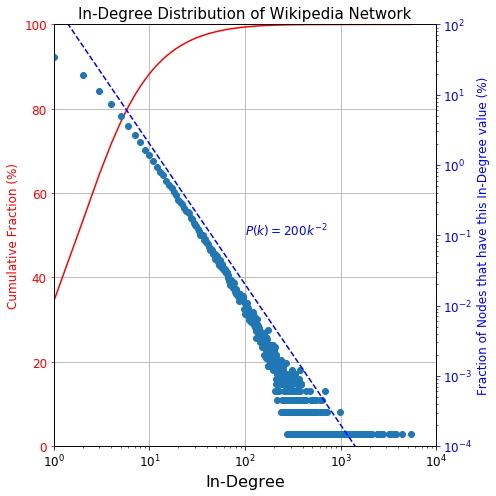

In [57]:
# Getting the fraction of people that each In-Degree value has
grouped=wikipedia_unified.dropna().groupby('number_mentions').count()
grouped['name']=grouped['name']/sum(grouped['name'])

#Calculating Power law curve
alpha=2
C=200
k=np.logspace(start=0,stop=4,num=10)
P=[C*ki**(-alpha) for ki in k]

#Plotting
fig,ax1=plt.subplots(figsize=(7,7))
ax2 = ax1.twinx() 

plt.title('In-Degree Distribution of Wikipedia Network',fontsize=15)
ax2.scatter(grouped.index,100*grouped['name'])
ax1.plot(grouped.index,np.cumsum(100*grouped['name']),'red')

ax2.annotate('$P(k)=200k^{-2}$',(100,0.1),fontsize=12,color='blue')
ax2.plot(k,P,color='blue',linestyle='--')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis='y', colors='blue')
ax1.tick_params(axis='y', colors='red')


ax2.set_ylim(10**-4,10**2)
plt.xlim(10**-0,10**4)
ax1.set_ylim(0,100)
ax1.set_xlabel('In-Degree',fontsize=16)
ax2.set_ylabel('Fraction of Nodes that have this In-Degree value (%)',fontsize=12,color='blue')
ax1.set_ylabel('Cumulative Fraction (%)',fontsize=12,color='red')
ax2.tick_params(axis='both', which='major', labelsize=12)

ax1.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
ax1.grid()


## 3.1 Birth year analysis

Before analysing the network, it is interesting to understand how the page mentions behave for different years of birth.

First, the people were grouped by decade of birth and the average number of mentions was calculated:

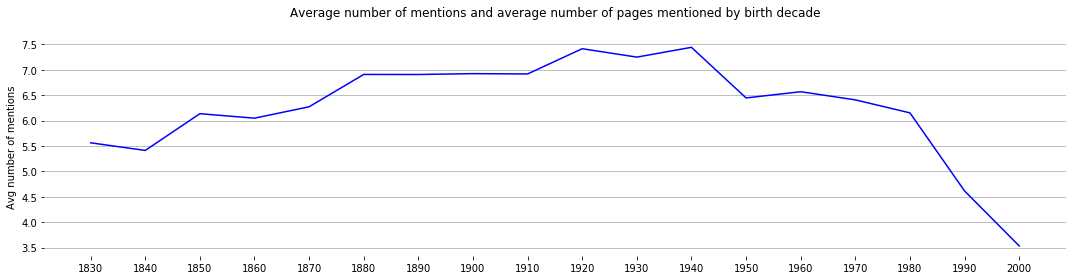

In [4]:
#Creating decades bins and averaging over them
bins= list(np.arange(1830,2003,10))+[2003]
wikipedia_unified['year_bin']=pd.cut(wikipedia_unified['birth_year'],bins,include_lowest=True)
average_by_decade=wikipedia_unified.groupby('year_bin').mean()
average_by_decade.index=[int(x) for x in np.arange(1830,2003,10)]

fig,(ax1)=plt.subplots(1,1,figsize=(15,4),sharex=True)
plt.subplots_adjust(hspace=0.1)
sns.lineplot(x=average_by_decade.index,y='number_mentions',data=average_by_decade,color='blue',ax=ax1,markers='o')
ax1.grid(axis='y')
ax1.set_ylabel('Avg number of mentions')

for ax in [ax1]:
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
plt.xticks(np.arange(1830,2003,10))
plt.title('Average number of mentions and average number of pages mentioned by birth decade\n');
plt.tight_layout()

The birth decades of the most referenced pages are 1920, 1930 and 1940, while the less referenced decades were from people born after 1980.

In [5]:
#Finding the age difference between each connection
difference_list=[]
for index,row in wikipedia_unified.iterrows():
    difference_list+=list(row['year_difference_vector'])

In [74]:
md(('Secondly, it is interesting to understand how different is the age of the referenced person and the person that'
   ' referenciates. All **{}** connections inside the network had their difference calculated.'
    '\nAs seen in the graph below, most people had an age very close to the pages it was referenced by.'.format(len(difference_list))))

Secondly, it is interesting to understand how different is the age of the referenced person and the person that referenciates. All **4353922** connections inside the network had their difference calculated.
As seen in the graph below, most people had an age very close to the pages it was referenced by.

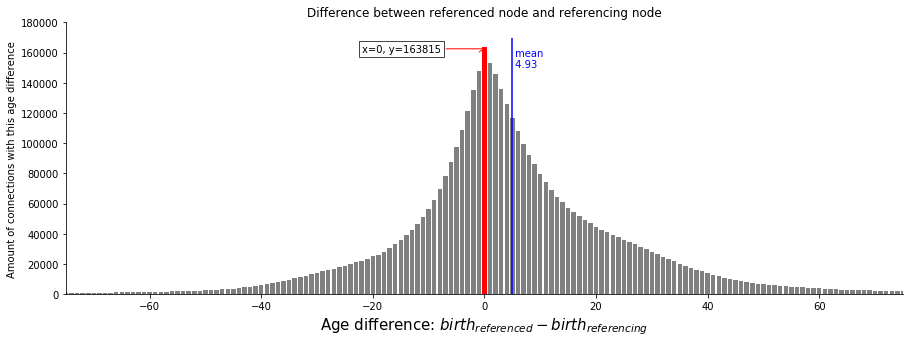

In [58]:
#Function to add annotation to top bar of the barplot
def annot_max(x,y, ax=None):
    dict_values=dict(zip(x,y))
    xmax=max(dict_values.items(),key=operator.itemgetter(1))[0]
    ymax=max(y)

    text= "x={:.0f}, y={:.0f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60",color='red')
    kw = dict(xycoords='data',textcoords="data",
              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax-22,ymax+2000), **kw)
    return xmax,ymax

#Counting the number of occurrences grouped by age difference
difference_count=Counter(difference_list)
mean_diff=np.mean(difference_list)

#Plot
fig,ax=plt.subplots(figsize=(15,5))

clrs = ['grey' if (x < max(difference_count.values())) else 'red' for x in difference_count.values() ]
labels = ['grey' if (x < max(difference_count.values())) else 'red' for x in difference_count.values() ]


ax.bar(difference_count.keys(),difference_count.values(),color=clrs)
ax.vlines(mean_diff,0,170000,color='blue')
ax.text(mean_diff,150000,' mean\n {:.2f}'.format(mean_diff),rotation=0,color='blue')

xmax,ymax=annot_max(difference_count.keys(),difference_count.values())

ax.set_ylim(0,180000)
ax.set_xlim(-75,75)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.title('Difference between referenced node and referencing node')
plt.ylabel('Amount of connections with this age difference')
plt.xlabel('Age difference: $birth_{referenced}-birth_{referencing}$',size=15);

In [75]:
md(('In fact, the most common age difference was equal to **{:.0f}** and occurred for **{}** connections.'
   '\n By calculating the average difference between the connections, it was found that '
   'the pages usually referenced people that were on average **{:.1f}** years older.').format(xmax,ymax,mean_diff,mean_diff))

In fact, the most common age difference was equal to **0** and occurred for **163815** connections.
 By calculating the average difference between the connections, it was found that the pages usually referenced people that were on average **4.9** years older.

## 4. Studying Directional Networks using a reduced network

Before the main analysis, a smaller network will be explored where some of the key concepts and definitions of a directional network will be presented.

To better visualize the way a directional network works, a smaller number of pages will be used. In this case, only the pages which are referenced by at least **1800** other pages will be considered.

In [9]:
#Keeping only people that were referenced by at least 1800 other wikipedia pages to perform an initial analysis of the
#MultiDirectional Network

minimum_mentions=1800

filtered_members=wikipedia_unified[wikipedia_unified['number_mentions']>minimum_mentions]['name']
wikipedia_unified_filtered=wikipedia_unified[wikipedia_unified['number_mentions']>minimum_mentions]
wikipedia_unified_filtered.loc[:,'links_filtered']=wikipedia_unified_filtered['links'].apply(lambda x: list(set(x).intersection(filtered_members)))

#Converting strings to readable format
wikipedia_unified_filtered.loc[:,'name']=wikipedia_unified_filtered['name'].apply(lambda x:unquote(x))
wikipedia_unified_filtered.loc[:,'links_filtered']=wikipedia_unified_filtered['links_filtered'].apply(lambda x:[unquote(x0) for x0 in x])
dict_network=dict(zip(wikipedia_unified_filtered['name'],wikipedia_unified_filtered['links_filtered']))

#Creating directional network
net=nx.DiGraph(dict_network)


#Processing features and giving them as attributes to the network
year_dict=dict(zip(wikipedia_unified_filtered['name'],wikipedia_unified_filtered['birth_year']))
number_mentions_dict=dict(zip(wikipedia_unified_filtered['name'],wikipedia_unified_filtered['number_mentions']))
names_dict=dict(zip(wikipedia_unified_filtered['name'],wikipedia_unified_filtered['name']))

nx.set_node_attributes(net, year_dict, 'year')
nx.set_node_attributes(net, number_mentions_dict, 'number_mentions')


#Obtaining the strongly connected subset of the network that has the highest number of nodes.
subnets = sorted(nx.strongly_connected_components(net), key=len,reverse=True)
main_net=net.subgraph(subnets[0])



In [76]:
md('A total of **{}** pages fit this criteria. The network containing these pages is shown below.'.format(len(net)))

A total of **17** pages fit this criteria. The network containing these pages is shown below.

In [11]:
def plot_net(net):
    node_size = [1*nx.get_node_attributes(net, 'number_mentions')[v] for v in net]
    node_color = [1*nx.get_node_attributes(net, 'year')[v] for v in net]

    cmap = plt.cm.autumn
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(node_color), vmax=max(node_color)))

    fig,ax=plt.subplots(figsize=(14,14))

    pos = nx.shell_layout(net)

    nodes = nx.draw_networkx_nodes(net, pos, node_size=node_size, node_color=node_color,cmap=cmap,edgecolors='black',
                                   norm=plt.Normalize(vmin = min(node_color), vmax=max(node_color)),alpha=0.9)
    edges = nx.draw_networkx_edges(
        net,
        pos,
        node_size=node_size,
        arrowstyle="->",
        arrowsize=20,
        edge_color='black',
        width=2,
        alpha=0.4,
    )
    labels=nx.draw_networkx_labels(net,pos,node_labels=names_dict,font_size=10,bold=True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    cbar=plt.colorbar(sm)
    plt.title('Directional network of pages with at least 1800 mentions')
    plt.annotate('The size of the nodes represent\n the amount of mentions',(0.5,-1.1))
    cbar.ax.set_ylabel('Birth year', rotation=90)


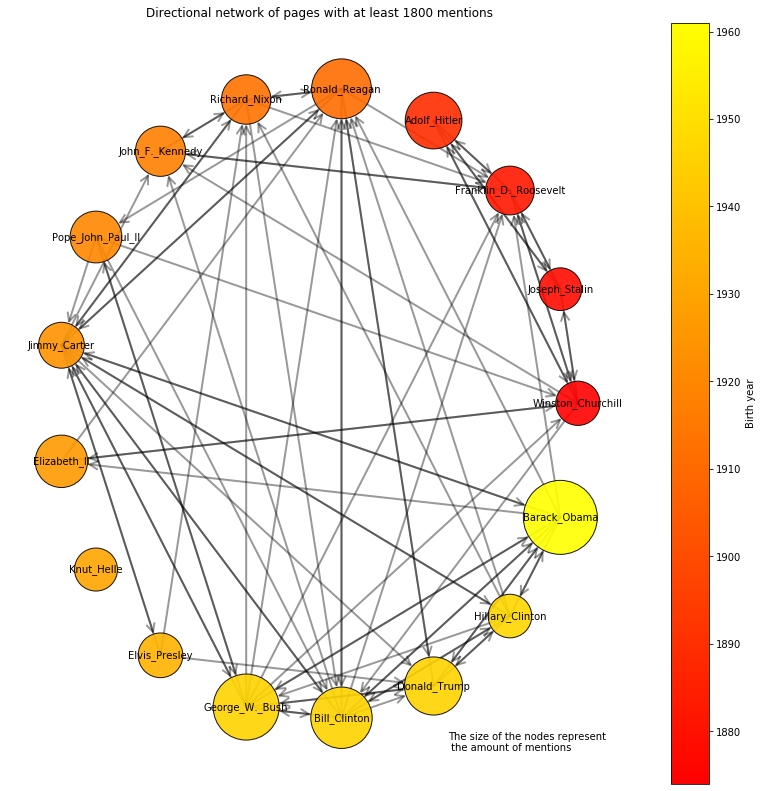

In [12]:
plot_net(net)

Each page is represented by a circle, which is called a node. Each reference is represented by an arrow, which is called an edge.

The size of each circle represents the number of times the node is referenced by all the other pages. Barack Obama is the most referenced page of the dataset, with a total of **5472** mentions.

The circles are colored and ordered according to the year of birth, Winston Churchill has the smallest birth year, while Obama has the highest.

The arrow points from the referencing page to the page it references. Exemplifying with Elizabeth_II:
* Elizabeth's page is referenced by Obama's page;
* Elizabeth's page references Reagan's page;
* Elizabeth's page both references and is referenced by Churchill's page.

One interesting thing to notice in this network is that not all nodes are connected: Knut_Helle neither mentions or is mentioned by the other nodes. Because the node is not connected to the network, it node prevents the use of multiple metrics.

For the analysis of a directional network, it is particularly interesting when the network is strongly connected, as some properties can only be calculated in this type of network. A strongly connected network is a netw
* All nodes are capable of reaching any other node of the network by following the direction of the edges.


In [77]:
md('In the case of this network, the strongly connected subset with the highest number of nodes has **{}** nodes and is show below'.format(len(main_net)))

In the case of this network, the strongly connected subset with the highest number of nodes has **16** nodes and is show below

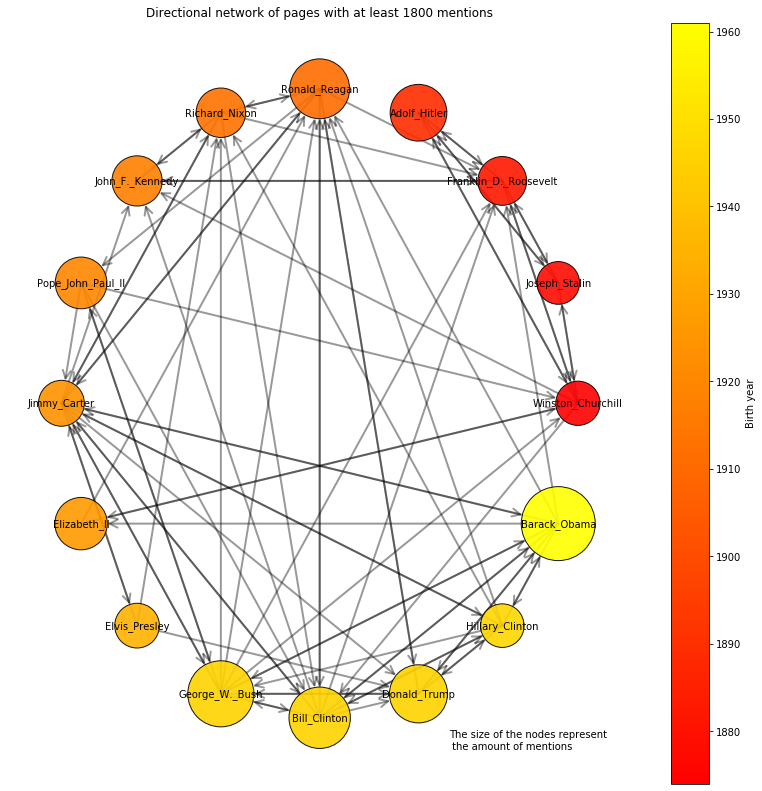

In [14]:
plot_net(main_net)

With this strongly connected network, some extra measurements can be performed.

Before showing these measures, some definitions are presented below:

* Distance (u,v) - Minimum number of edges needed to go from node u to node v.
* Shortest path (u,v) - Shortest sequence of nodes needed to go from node u to node v.

<!--* Diameter (network) - Maximum distance between any pair of nodes.
* Eccentricity (node n) - largest distance between node n and all other nodes.
* Radius (network) - Minimum eccentricity.
* Periphery (network) - Set of nodes that have eccentricity equal to the Diameter.
* Center (network) - Set of nodes that have eccentricity equal to the radius.-->

As an example, the shortest path between Elvis_Presley and Barack_Obama is: Elvis Presley -> Jimmy Carter -> Barack Obama. It has a distance equal to **2**.


<!--The diameter of this network is equal to **4** (in other words, this is the maximum distance necessary to be traveled for any node to each any other node). The nodes which have their eccentricity equal to the diameter (in other words, they are in the periphery) are: Joseph Stalin, Franklin_D._Roosevelt and Adolf_Hitler. Stalin for example needs the following path to reach Pope_John_Paul_II: Joseph_Stalin -> Winston_Churchill-> Bill_Clinton-> Ronald_Reagan -> Pope_John_Paul_II (**4** edges in total).

The radius of the network is equal to **2**. The only nodes that are in the center (have eccentricity equal to the radius) are: Pope_John_Paul_II, George_W._Bush, Bill_Clinton and Barack_Obama. They only need **2** edges to reach any other node of the network.-->


## 5. Analysis of a big directional network

Now that the main definitions were presented in a simpler graph, the same approach is extended for a network with a much larger number of nodes.

This time, only pages that were referenced at least **120** times by other pages will be considered in the analysis. Not all pages were considered since processing more than 1 million nodes would have a very high computational cost.

In [15]:
#Same procedure as previous section, except this time the restrictions are smaller.
minimum_mentions=120

filtered_members2=wikipedia_unified[wikipedia_unified['number_mentions']>minimum_mentions]['name']

wikipedia_unified_filtered2=wikipedia_unified[wikipedia_unified['number_mentions']>minimum_mentions]


wikipedia_unified_filtered2.loc[:,'links_filtered']=wikipedia_unified_filtered2['links'].apply(lambda x: list(set(x).intersection(filtered_members2)))
wikipedia_unified_filtered2.loc[:,'name']=wikipedia_unified_filtered2['name'].apply(lambda x:unquote(x))
wikipedia_unified_filtered2.loc[:,'links_filtered']=wikipedia_unified_filtered2['links_filtered'].apply(lambda x:[unquote(x0) for x0 in x])

dict_network2=dict(zip(wikipedia_unified_filtered2['name'],wikipedia_unified_filtered2['links_filtered']))

year_dict2=dict(zip(wikipedia_unified_filtered2['name'],wikipedia_unified_filtered2['birth_year']))
number_mentions_dict2=dict(zip(wikipedia_unified_filtered2['name'],wikipedia_unified_filtered2['number_mentions']))
names_dict2=dict(zip(wikipedia_unified_filtered2['name'],wikipedia_unified_filtered2['name']))

#Building network
net2=nx.DiGraph(dict_network2)
nx.set_node_attributes(net2, year_dict2, 'year')
nx.set_node_attributes(net2, number_mentions_dict2, 'number_mentions')

#Getting biggest strongly connected subset
subnets = sorted(nx.strongly_connected_components(net2), key=len,reverse=True)
main_net2=net2.subgraph(subnets[0])
main_net2_names=list(main_net2.nodes)

In [16]:
#Counting the total number of connections in this network
wikipedia_unified_filtered_final=wikipedia_unified_filtered2[wikipedia_unified_filtered2['name'].isin(main_net2_names)]
wikipedia_unified_filtered_final.loc[:,'links_filtered']=wikipedia_unified_filtered_final['links'].apply(lambda x: list(set(x).intersection(main_net2_names)))

total_connections2=np.sum(wikipedia_unified_filtered_final['links_filtered'].apply(lambda x:len(x)))

In [78]:
md('There are a total of **{}** pages that fit this criteria. By considering only'.format(len(net2))+\
   ' the biggest strongly connected subset, the final network had a total of **{}** nodes.'.format(len(main_net2))+\
  '<br> Although this represents only **{:.2f}'.format(len(main_net2)/len(wikipedia_df)*100)+\
   '%** of all nodes, it represents **{:.2f}%** of all edge connections'.format(total_connections2/total_connections*100))

There are a total of **2961** pages that fit this criteria. By considering only the biggest strongly connected subset, the final network had a total of **2912** nodes.<br> Although this represents only **0.23%** of all nodes, it represents **1.34%** of all edge connections

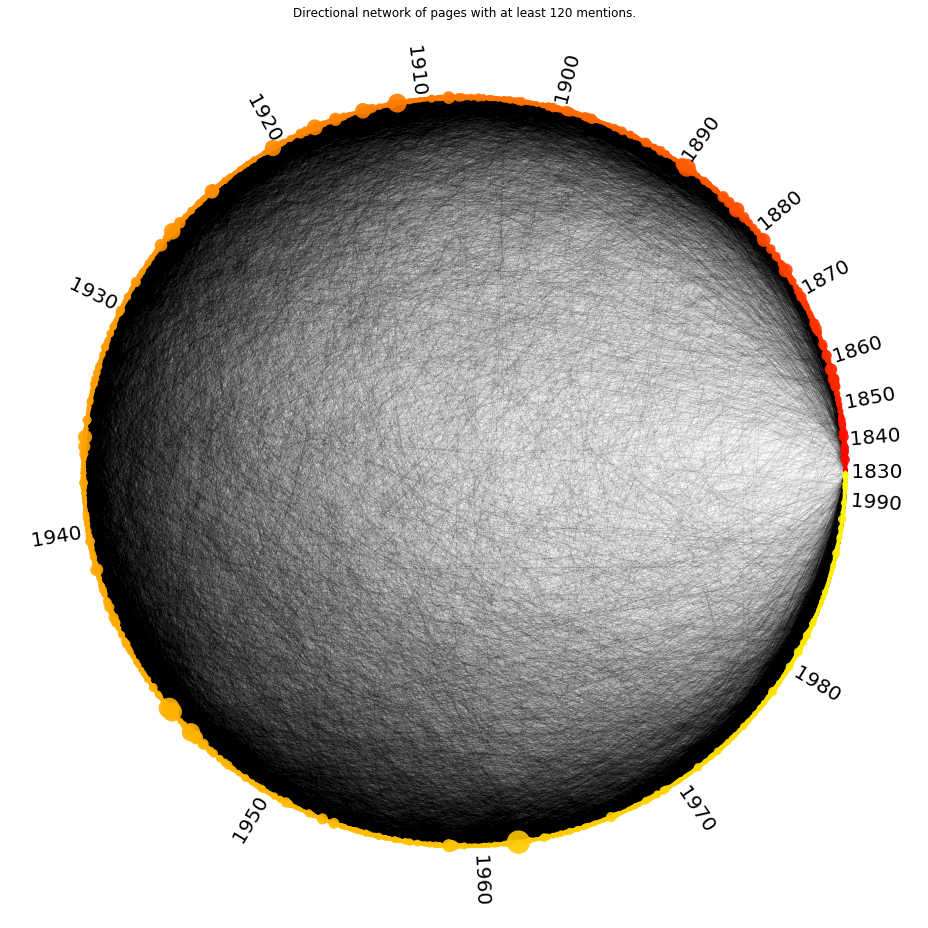

In [21]:
def return_year(key):
    return year_dict2[key]

#Creating a label dictionary containing the first person to be mentioned in a given decade
labels={}
start_year=1830
for lab in sorted(main_net2.nodes(),key=return_year):
    if year_dict2[lab]==start_year:
        labels[lab]=' {} '.format(year_dict2[lab])
        start_year+=10

# Node size and node color depending on the number of mentions and the birth year respectively
node_size = [0.1*nx.get_node_attributes(main_net2, 'number_mentions')[v] for v in main_net2]
node_color = [1*nx.get_node_attributes(main_net2, 'year')[v] for v in main_net2]

cmap = plt.cm.autumn
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(node_color), vmax=max(node_color)))

fig,ax=plt.subplots(figsize=(13,13))

#Network layout in a circular pattern
pos = nx.shell_layout(main_net2)

#Drawing nodes
nodes = nx.draw_networkx_nodes(main_net2, pos, node_size=node_size, node_color=node_color,cmap=cmap,edgecolors='black',
                               norm=plt.Normalize(vmin = min(node_color), vmax=max(node_color)),alpha=0.9,
                              linewidths =0)
#Drawing edges
edges = nx.draw_networkx_edges(
    main_net2,
    pos,
    node_size=node_size,
    arrowstyle="->",
    arrowsize=10,
    width=0.05,
    alpha=0.5
)

#Drawing labels and changing the angle accordingly to the position in the network
labels=nx.draw_networkx_labels(main_net2,pos,labels,font_size=20,bold=True,font_color ='black')
theta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in pos.items() }

for key,t in labels.items():
    if 90 < theta[key] or theta[key] < -90 :
        angle = 180 + theta[key]
        t.set_ha('right')
    else:
        angle = theta[key]
        t.set_ha('left')
    t.set_va('center')
    t.set_rotation(angle)
    t.set_rotation_mode('anchor')
    
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.title('Directional network of pages with at least {} mentions.'.format(minimum_mentions))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()

In [65]:
#Create list with shortest path from each pair of origin and destiny node
pathlengths=[]
for v in main_net2.nodes():
    spl = dict(nx.single_source_shortest_path_length(main_net2, v))
    for p in spl:
        if spl[p]==0:continue
        pathlengths.append(spl[p])
avg_shortest_path=sum(pathlengths) / len(pathlengths)
#for each node, find the shortest path. The diameter is the highest shortest path between two nodes in a network
diameter=(nx.diameter(main_net2))

#The nodes that have the highest shortest path equal to the diameter are in the periphery and are calculated below
periphery_nodes=nx.periphery(main_net2)

#for each node, find the shortest path. The radius is the minimum necessary distance for the central-most node to reach any other node
radius=nx.radius(main_net2)

#The nodes that have the highest shortest path equal to the radius are in the periphery and are shown below
central_nodes=nx.center(main_net2)

# Calculating the farthest node from a node in the periphery, as well as the shortest path between both
farthest_node=sorted(nx.shortest_path_length(main_net2,periphery_nodes[0]).items(),key=lambda item:item[1],reverse=True)[0][0]
shortest_path_two_nodes=nx.shortest_path(main_net2,periphery_nodes[0],farthest_node)

The network has a higher density of connections around the border region when compared to the center, which happens because, as seen before, the connections are usually between people born in a similar period.


In [66]:
md(('By calculating the shortest path between each pair of nodes and taking their average it is foundnd that it takes on average '
   '**{:.1f}** edges for each page to reach the other. \n From the histogram below, most nodes have a distance'
   ' of **3** edges between themselves.').format(avg_shortest_path))

By calculating the shortest path between each pair of nodes and taking their average it is foundnd that it takes on average **3.5** edges for each page to reach the other. 
 From the histogram below, most nodes have a distance of **3** edges between themselves.

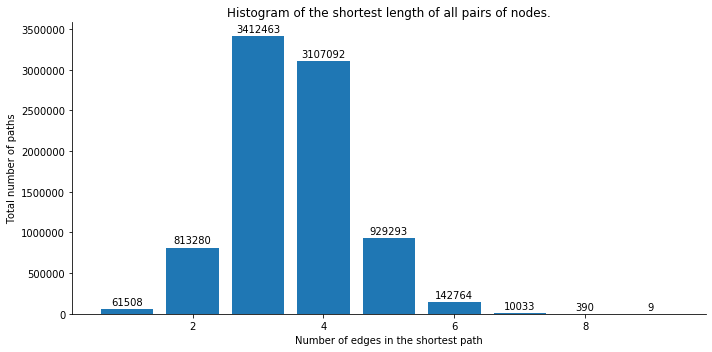

In [24]:
#Creating histogram by grouping node connections by their shortest path length
path_lengths_count=Counter(pathlengths)
fig,ax=plt.subplots(figsize=(10,5))
ax.bar(path_lengths_count.keys(),path_lengths_count.values())

for i, v in enumerate(path_lengths_count.keys()):
    ax.text(v, path_lengths_count[v]+50000, str(path_lengths_count[v]), color='black',ha='center')
plt.title('Histogram of the shortest length of all pairs of nodes.')
plt.xlabel('Number of edges in the shortest path')
plt.ylabel('Total number of paths')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
#plt.yscale('log')

In [25]:
farthest_node=sorted(nx.shortest_path_length(main_net2,periphery_nodes[0]).items(),key=lambda item:item[1],reverse=True)[0][0]
shortest_path_two_nodes=nx.shortest_path(main_net2,periphery_nodes[0],farthest_node)


In [72]:
md(('The largest distance between two nodes is equal to **{}**. As an example, to go from node **{}** to node **{}**, '
    'the shortest path is: {}.')
    .format(diameter,periphery_nodes[0],farthest_node,' -> '.join(shortest_path_two_nodes)))

The largest distance between two nodes is equal to **9**. As an example, to go from node **George_Călinescu** to node **Mervana_Jugić-Salkić**, the shortest path is: George_Călinescu -> Mihai_Eminescu -> Nicolae_Iorga -> Carol_II_of_Romania -> Neville_Chamberlain -> Elizabeth_II -> Annie_Leibovitz -> Serena_Williams -> Marion_Bartoli -> Mervana_Jugić-Salkić.

It is possible to follow this path starting from: https://en.wikipedia.org/wiki/George_C%C4%83linescu. (Obs: This was possible at the moment this article was written. However, if the pages are updated, this sequence of links may not work)

<h2><center>Example of a shortest path with a length of 9</center></h2>

<table><tr>
<td> <img src="images/George_Călinescu.jpg" alt="Drawing" style="height: 150px;"/> </td>
<td> <img src="images/Mihai_Eminescu.jpg" alt="Drawing" style="height: 150px;"/> </td>
<td> <img src="images/Nicolae_Iorga.jpg" alt="Drawing" style="height: 150px;"/> </td>
<td> <img src="images/George_Enescu.jpg" alt="Drawing" style="height: 150px;"/> </td>
<td> <img src="images/Pierre_Monteux.jpg" alt="Drawing" style="height: 150px;"/> </td>
<td> <img src="images/Josephine_Baker.jpg" alt="Drawing" style="height: 150px;"/> </td>
<td> <img src="images/Beyoncé2.jpg" alt="Drawing" style="height: 150px;"/> </td>
<td> <img src="images/Serena_Williams.jpg" alt="Drawing" style="height: 150px;"/> </td>
<td> <img src="images/Sorana_Cîrstea.jpg" alt="Drawing" style="height: 150px;"/> </td>
<td> <img src="images/Irina_Khromacheva2.jpg" alt="Drawing" style="height: 150px;"/> </td>

</tr><tr>
<td> George_Călinescu</td>
<td>Mihai_Eminescu   </td>
<td>Nicolae_Iorga   </td>
<td>George_Enescu  </td>
<td>Pierre_Monteux  </td>
<td>Josephine_Baker  </td>
<td>Beyoncé_Giselle</td>
<td>Serena_Williams </td>
<td>Sorana_Cîrstea </td>
<td>Irina_Khromacheva </td>
</tr><tr>
<td>Romanian Literacy Critic </td>
<td>Romanian Poet  </td>
<td>Romanian Prime-Minister  </td>
<td>Romanian Compositor  </td>
<td>French Compositor  </td>
<td>American Singer (naturalized French)  </td>
<td>American Singer  </td>
<td>American Tennis Player  </td>
<td>Romanian Tennis Player  </td>
<td>Russian Tennis Player  </td>
</tr><tr>
<td>1899-1965 </td>
<td>1850-1889</td>
<td>1871-1940  </td>
<td>1881-1955  </td>
<td>1875-1964  </td>
<td>1906-1975  </td>
<td>1981-present  </td>
<td>1981-present  </td>
<td>1990-present  </td>
<td>1995-present  </td>
</tr></table>

In [73]:
md(('On the other hand, the most central nodes need to use only **{}** edges to reach all other nodes in the network.'
   'These central nodes are: {}.').format(radius, ', '.join(central_nodes)))

On the other hand, the most central nodes need to use only **5** edges to reach all other nodes in the network.These central nodes are: Bob_Hope, Johnny_Carson, Johnny_Cash, Peter_O'Toole, Judi_Dench, Dustin_Hoffman, Tina_Turner, Barbra_Streisand, George_Lucas, Diana_Ross, Cher, Linda_Ronstadt, Glenn_Close, David_Letterman, Howard_Dean, Grace_Jones, Annie_Leibovitz, Cameron_Crowe, Daniel_Day-Lewis, Gary_Oldman, Prince_(musician), Bono, Sean_Penn, Steve_Carell, Jodie_Foster, Demi_Moore, Quentin_Tarantino, Kiefer_Sutherland, Philip_Seymour_Hoffman, Nicole_Kidman, Tim_McGraw, Celine_Dion, Jennifer_Aniston, Jennifer_Lopez, Lance_Armstrong, Kanye_West, Christina_Aguilera, Jake_Gyllenhaal, Natalie_Portman, Justin_Timberlake, Lady_Gaga, Miley_Cyrus.

## 5.1 Network's most important nodes

The next step in the network analysis is to find which nodes are the most important in the network. However, there are multiple ways to define the importance of a node:

* A node that is referenced by many nodes;
* A node that references many nodes;
* A node that disseminates information to many nodes;
* A node that prevents the network from breaking up;
* A node that acts as an intermediary for many other node connection;

Five different metrics will be explored in this section

The table below shows the top 10 performing nodes in each metric, as well as their score in the metric.

In [28]:
#Getting centrality measurements
in_degree=nx.in_degree_centrality(main_net2).items()
out_degree=nx.out_degree_centrality(main_net2).items()
closeness_centr=nx.closeness_centrality(main_net2).items()
betweenness_centr=nx.betweenness_centrality(main_net2).items()
pagerank=nx.pagerank(main_net2,alpha=0.8).items()
hubs=nx.hits(main_net2)[0].items()
authorities=nx.hits(main_net2)[1].items()

#Obtaining top 10 values for each category
in_degree_10=sorted(in_degree,key=lambda x:x[1],reverse=True)[:10]
out_degree_10=sorted(out_degree,key=lambda x:x[1],reverse=True)[:10]
closeness_centr_10=sorted(closeness_centr,key=lambda x:x[1],reverse=True)[:10]
betweenness_centr_10=sorted(betweenness_centr,key=lambda x:x[1],reverse=True)[:10]
pagerank_10=sorted(pagerank,key=lambda x:x[1],reverse=True)[:10]
hubs_10=sorted(hubs,key=lambda x:x[1],reverse=True)[:10]
authorities_10=sorted(authorities,key=lambda x:x[1],reverse=True)[:10]


In [29]:
df10=pd.DataFrame(map(list,zip(*[in_degree_10,out_degree_10,closeness_centr_10,betweenness_centr_10,pagerank_10])),
                 columns=['in_degree','out_degree','closeness_centrality','betweenness_centrality','pagerank'])
df10.index=[1,2,3,4,5,6,7,8,9,10]
df10.index.name='Rank'
df10

in_degree  \
Rank                                            
1         (Barack_Obama, 0.12332531776021986)   
2       (George_W._Bush, 0.08965991068361388)   
3         (Ronald_Reagan, 0.0724836825833047)   
4         (Donald_Trump, 0.06904843696324288)   
5          (Bill_Clinton, 0.0666437650291996)   
6         (Elizabeth_II, 0.06149089659910684)   
7     (Hillary_Clinton, 0.061147372037100654)   
8        (Elvis_Presley, 0.05874270010305737)   
9         (Adolf_Hitler, 0.05668155273102027)   
10     (John_F._Kennedy, 0.05668155273102027)   

                                      out_degree  \
Rank                                               
1                (Bob_Dylan, 0.0333218825145998)   
2        (Martin_Scorsese, 0.031260735142562696)   
3            (Meryl_Streep, 0.03091721058055651)   
4          (Frank_Sinatra, 0.030573686018550327)   
5              (Kanye_West, 0.02885606320851941)   
6            (Gary_Cooper, 0.027138440398488492)   
7                (Beyoncé, 0.027138440398488492)   
8         (Ennio_Morricone, 0.02679491583648231)   
9     (Daniela_Hantuchová, 0.026451391274476127)   
10         (Clint_Eastwood, 0.02610786671246994)   

                              closeness_centrality  \
Rank                                                 
1               (Barack_Obama, 0.4520888336698245)   
2            (George_W._Bush, 0.43577844311377245)   
3              (Ronald_Reagan, 0.4315149718351616)   
4                (Bill_Clinton, 0.430812490750333)   
5              (Donald_Trump, 0.42360302677532014)   
6              (Elizabeth_II, 0.41651166118185723)   
7              (Richard_Nixon, 0.4137882018479033)   
8           (John_F._Kennedy, 0.41320085166784953)   
9     (Franklin_D._Roosevelt, 0.40971147079521464)   
10          (Hillary_Clinton, 0.40577083914134376)   

                       betweenness_centrality  \
Rank                                            
1      (Serena_Williams, 0.02713920766284382)   
2       (George_W._Bush, 0.02158026495197759)   
3        (Elizabeth_II, 0.021020400761442314)   
4        (David_Beckham, 0.01751936600273064)   
5        (Barack_Obama, 0.016922862929749354)   
6       (Frank_Sinatra, 0.016193138703061737)   
7           (Bob_Dylan, 0.016134896130850146)   
8     (Martin_Scorsese, 0.014452622611500002)   
9          (Elton_John, 0.014322549178870965)   
10      (Ronald_Reagan, 0.013940702523319047)   

                                            pagerank  
Rank                                                  
1               (Barack_Obama, 0.005520359466833555)  
2             (George_W._Bush, 0.004584363936164377)  
3               (Adolf_Hitler, 0.004237462371200238)  
4               (Bill_Clinton, 0.003712476546043592)  
5              (Ronald_Reagan, 0.003701233952903178)  
6     (Franklin_D._Roosevelt, 0.0036448094355757995)  
7               (Donald_Trump, 0.003468004351337716)  
8         (Winston_Churchill, 0.0032940765232184724)  
9             (John_F._Kennedy, 0.00317726308689229)  
10            (Richard_Nixon, 0.0031765386983013473)

In [30]:
#Function to plot network with focus on a specific person. Show both edges that come in and out of this node.
def plot_candidate(person,title):
    
    labels={}
    start_year=1830
    for lab in sorted(main_net2.nodes(),key=return_year):
        if lab==person:
            labels[lab]=' '+lab+' '
        if year_dict2[lab]==start_year:
            labels[lab]=' {} '.format(year_dict2[lab])
            start_year+=10
    
    colors=[]
    widths=[]
    referenciates=[]
    referenced_by=[]
    for edge in main_net2.edges():
        if edge[0]==person:
            colors+=['blue']
            widths+=[3]
            referenciates+=[edge[1]]

        elif edge[1]==person:
            colors+=['red']
            widths+=[3]
            referenced_by+=[edge[0]]
        else:
            colors+=['black']
            widths+=[0.05]
            

    node_size = [0.05*nx.get_node_attributes(main_net2, 'number_mentions')[v] for v in main_net2]
    node_color = [1*nx.get_node_attributes(main_net2, 'year')[v] for v in main_net2]

    cmap = plt.cm.autumn
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(node_color), vmax=max(node_color)))

    fig,ax=plt.subplots(figsize=(15,15))
    
    pos = nx.circular_layout(main_net2)
    
    theta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in pos.items() }

    
    nodes = nx.draw_networkx_nodes(main_net2, pos, node_size=node_size, node_color=node_color,cmap=cmap,edgecolors='black',
                                   norm=plt.Normalize(vmin = min(node_color), vmax=max(node_color)),alpha=0.9,with_labels=False,
                                  linewidths =0)
    edges_draw = nx.draw_networkx_edges(
        main_net2,
        pos,
        node_size=node_size,
        arrowstyle="->",
        arrowsize=10,
        width=widths,
        alpha=0.2,
        edge_color=colors
    )
    labels=nx.draw_networkx_labels(main_net2,pos,labels,font_size=15,bold=True,font_color ='green')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.title(title,fontsize=20)
    for key,t in labels.items():
        if 90 < theta[key] or theta[key] < -90 :
            angle = 180 + theta[key]
            t.set_ha('right')
        else:
            angle = theta[key]
            t.set_ha('left')
        t.set_va('center')
        t.set_rotation(angle)
        t.set_rotation_mode('anchor')
    plt.xlim(-1.4,1.4)
    plt.ylim(-1.4,1.4)
    plt.tight_layout()
    return referenciates,referenced_by


### 5.1.1 In-degree centrality

A node which is referenced by many people will have a higher In-degree value.

This metric is calculated for each node by dividing the total number of nodes that reference this node by the total number of nodes in the network.
<!--<font size="5">-->
     
<center>$C_{indeg}(v)=\frac{d_{v}^{in}}{N-1}$</center>
     
      
      
N=set of nodes in the network
     
     
    
$d_{v}^{in}$= in-degree value of node
     
<!--</font>-->



In [70]:
md(('The node with the highest in-degree score is **{}**, which is referenced by **{:.1f}%** of all  nodes '
   'of the network. This node relationships'+"'"+' are shown below, where the red arrows point from the referenciator nodes ' 
    'towards **{}** and the blue arrows point from **{}** to the nodes it references. As expected, this node has a very high number of'
    ' points pointing to it.'
    '\n\n The top 10 highest performing nodes were: {}.'
   ).format(df10.iloc[0]['in_degree'][0],df10.iloc[0]['in_degree'][1]*100,df10.iloc[0]['in_degree'][0],
            df10.iloc[0]['in_degree'][0],', '.join([x[0] for x in df10['in_degree']])))

The node with the highest in-degree score is **Barack_Obama**, which is referenced by **12.3%** of all  nodes of the network. This node relationships' are shown below, where the red arrows point from the referenciator nodes towards **Barack_Obama** and the blue arrows point from **Barack_Obama** to the nodes it references. As expected, this node has a very high number of points pointing to it.

 The top 10 highest performing nodes were: Barack_Obama, George_W._Bush, Ronald_Reagan, Donald_Trump, Bill_Clinton, Elizabeth_II, Hillary_Clinton, Elvis_Presley, Adolf_Hitler, John_F._Kennedy.

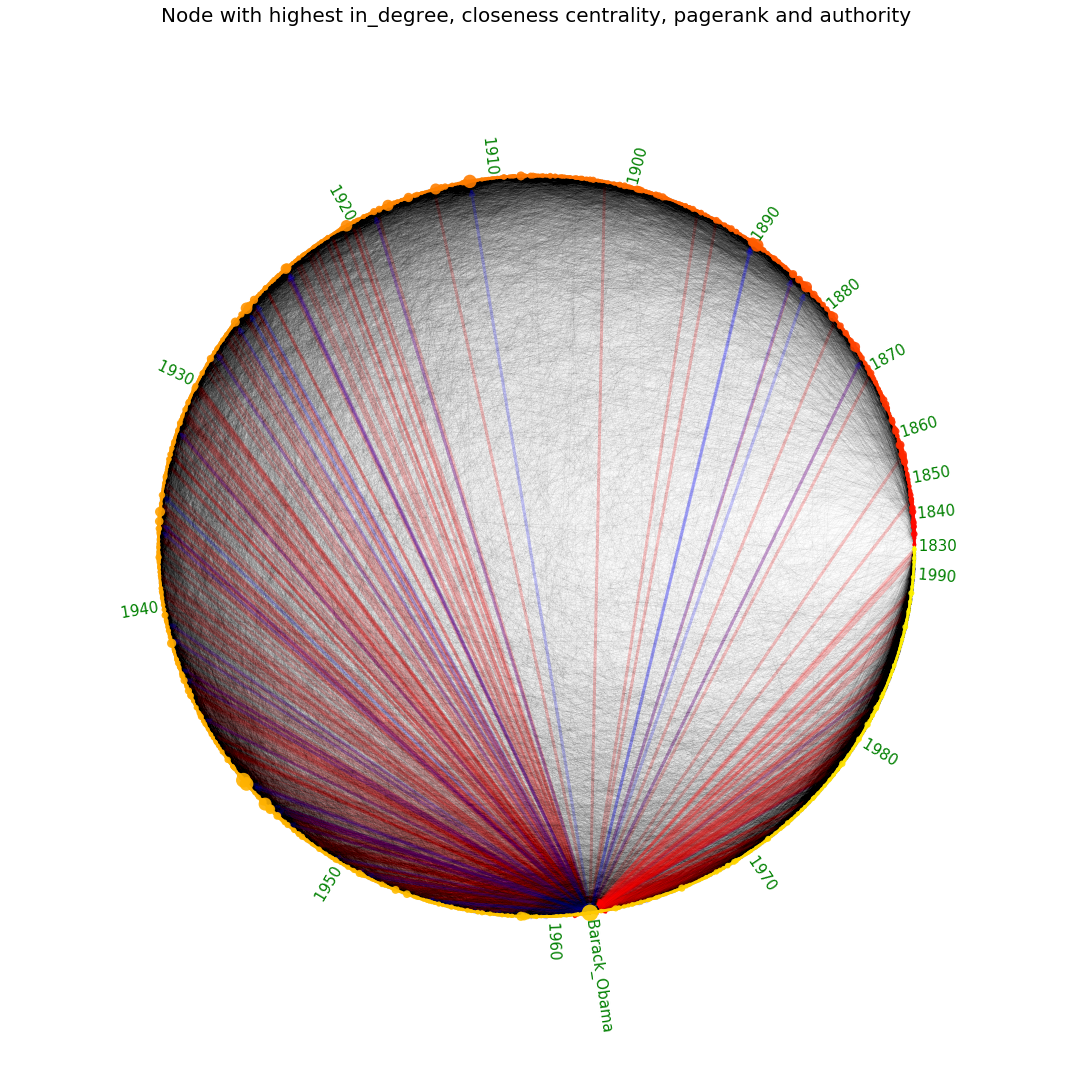

In [47]:
ref,ref_by=plot_candidate(df10.iloc[0]['in_degree'][0],'Node with highest in_degree, closeness centrality, pagerank and authority')

In [48]:
len(ref_by)

359

### 5.1.2 Out-degree centrality

A node which references many people will have a higher Out-degree value.

This metric is calculated for each node by dividing the total number of nodes that it references by the total number of nodes in the network.

<!--<font size="5">-->
     
<center>$C_{outdeg}(v)=\frac{d_{v}^{out}}{N-1}$</center>
     
      
      
N=set of nodes in the network
     
     
    
$d_{v}^{out}$= out-degree value of node
     
<!--</font>-->

In [69]:
md(('The node with the highest out-degree score is **{}**, which references **{:.1f}%** of all  nodes '
   'of the network. This node relationships'+"'"+' are shown below, where the red arrows point from the referenciator nodes ' 
    'towards **{}** and the blue arrows point from **{}** to the nodes it references. As expected, the node has a high number'
    ' of people it references.'
    '\n\n The top 10 highest performing nodes were: {}.'
   ).format(df10.iloc[0]['out_degree'][0],df10.iloc[0]['out_degree'][1]*100,df10.iloc[0]['out_degree'][0],
            df10.iloc[0]['out_degree'][0],', '.join([x[0] for x in df10['out_degree']])))

The node with the highest out-degree score is **Bob_Dylan**, which references **3.3%** of all  nodes of the network. This node relationships' are shown below, where the red arrows point from the referenciator nodes towards **Bob_Dylan** and the blue arrows point from **Bob_Dylan** to the nodes it references. As expected, the node has a high number of people it references.

 The top 10 highest performing nodes were: Bob_Dylan, Martin_Scorsese, Meryl_Streep, Frank_Sinatra, Kanye_West, Gary_Cooper, Beyoncé, Ennio_Morricone, Daniela_Hantuchová, Clint_Eastwood.

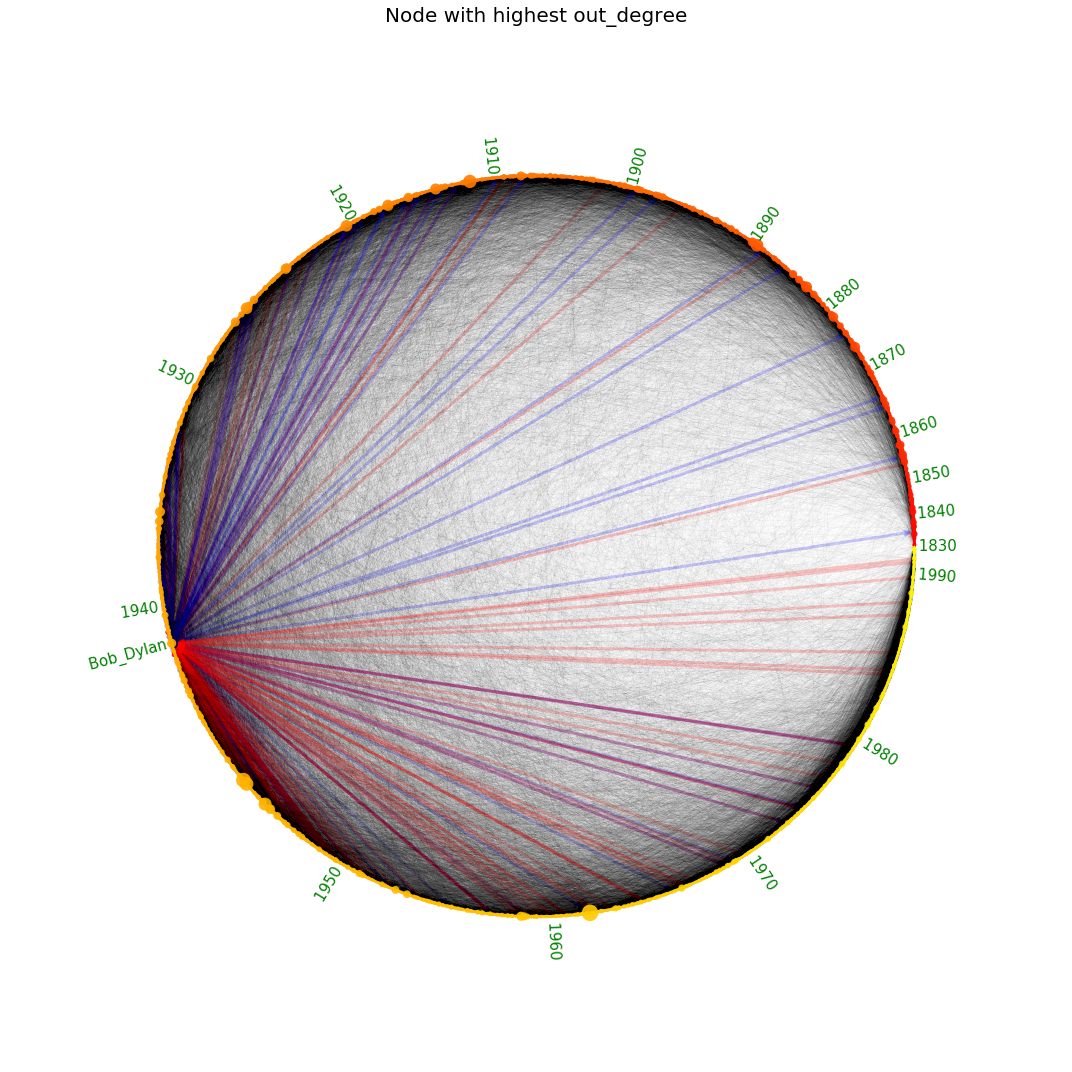

In [34]:
ref,ref_by=plot_candidate(df10.iloc[0]['out_degree'][0],'Node with highest out_degree')

### 5.1.3 Closeness centrality



This metric considers that the most important nodes are the ones closest to the rest of the network.

A node where the average shortest path length is low will score well with this metric.

It is calculated by dividing the total number of nodes in the network by the sum of the shortest path lengths from this node to the remaining nodes.

<!--<font size="5">-->
    
     
<center>$C_{close}(v)=\frac{N-1}{\sum_{u \in N, u \neq v}d(v,u)}$</center>
     
          
N=set of nodes in the network
    
d(v,u)= length of shortest path from v to u
     
        
<!--</font>-->


In [67]:
highest_closeness_centr_node=df10.iloc[0]['closeness_centrality'][0]

md(('The node with the highest closeness centrality is **{}**, which has a closeness centrality of **{:.2f}**'
    '.'
    '\n\n The top 10 highest performing nodes were: {}.'
   ).format(df10.iloc[0]['closeness_centrality'][0],df10.iloc[0]['closeness_centrality'][1],
                ', '.join([x[0] for x in df10['closeness_centrality']])))

The node with the highest closeness centrality is **Barack_Obama**, which has a closeness centrality of **0.45**.

 The top 10 highest performing nodes were: Barack_Obama, George_W._Bush, Ronald_Reagan, Bill_Clinton, Donald_Trump, Elizabeth_II, Richard_Nixon, John_F._Kennedy, Franklin_D._Roosevelt, Hillary_Clinton.

### 5.1.4 Betweenness centrality

This metric considers that the most important nodes are the ones that connect other nodes.

The nodes where most shortest paths pass through will have a high betweenness centrality.


It is calculated using the expression:

<!--<font size="5">-->
    
     
     
<center>$C_{btw}(v)=\sum_{s,t \in N}\frac{\sigma_{s,t}(v)}{\sigma_{s,t}}$</center>
          
$\sigma_{s,t}$ = Number of shortest paths between nodes s and t

$\sigma_{s,t}(v)$ = Number of shortest paths between nodes s and t that pass through node v.

     
        
<!--</font>-->


In [68]:
md(('The node with the highest betweenness centrality is **{}**, which has a value of **{:.3f}**.'
    '\n\n The top 10 highest performing nodes were: {}.'
   ).format(df10.iloc[0]['betweenness_centrality'][0],df10.iloc[0]['betweenness_centrality'][1],
            ', '.join([x[0] for x in df10['betweenness_centrality']])))

The node with the highest betweenness centrality is **Serena_Williams**, which has a value of **0.027**.

 The top 10 highest performing nodes were: Serena_Williams, George_W._Bush, Elizabeth_II, David_Beckham, Barack_Obama, Frank_Sinatra, Bob_Dylan, Martin_Scorsese, Elton_John, Ronald_Reagan.

Serena Williams was a very important node since there was a high number of Tennis players in the database, and most of the connections between those and the rest of the database went through Williams (Obs:Tennis players pages normally reference the opponents of the most important games, meaning that there are a high number of players, as well as nationalities mentioned). Furthermore, Serena mentioned important nodes from other professions (Alicia_Keys, Kanye_West) and was mentioned as well by different professions (Beyoncé, Lionel_Messi).

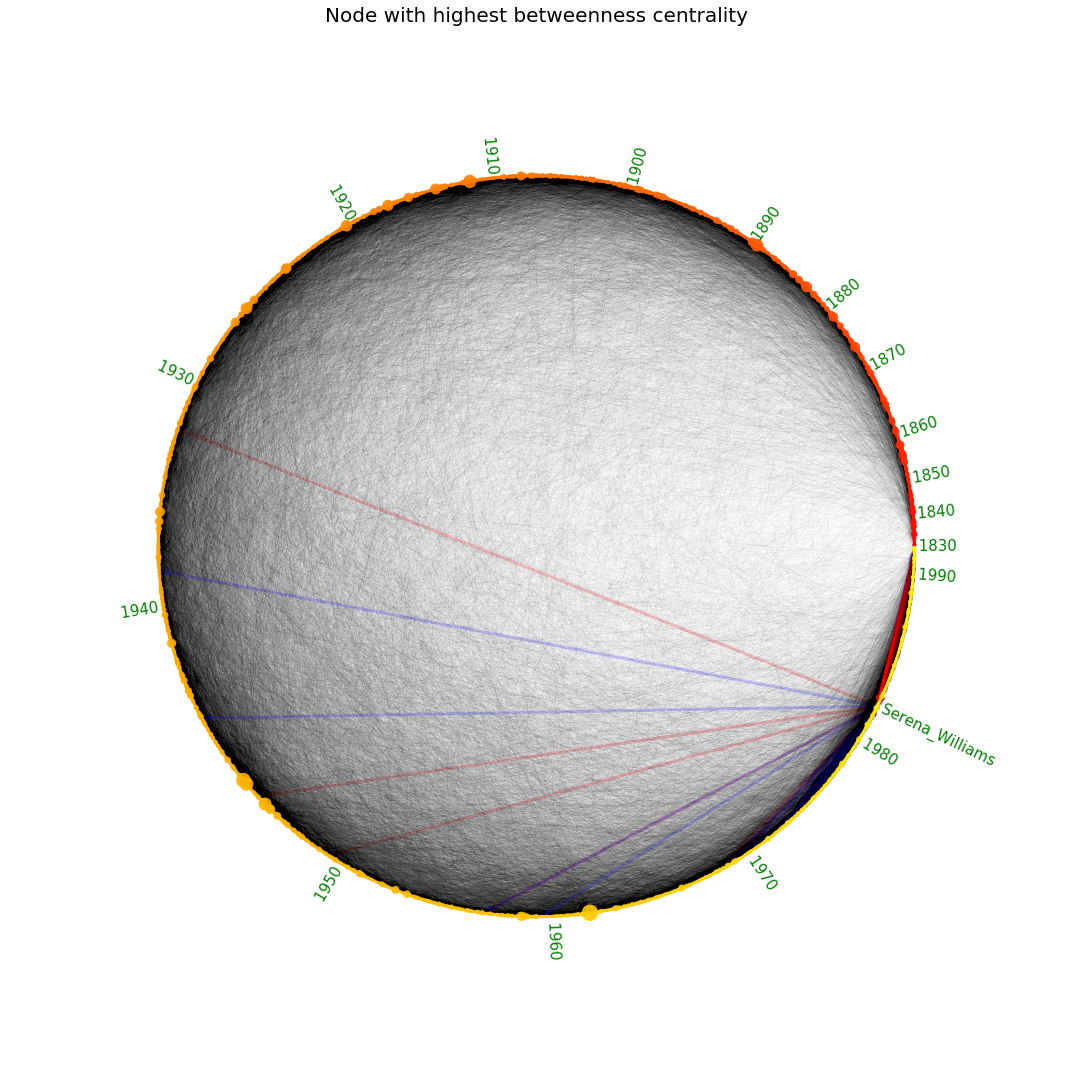

In [44]:
ref,ref_by=plot_candidate(df10.iloc[0]['betweenness_centrality'][0],'Node with highest betweenness centrality')

### 5.1.5 Page rank

Page rank is an iterative method that was developed by google founders to measure the importance of webpages. It assigns a score of importance to each node, where important nodes are those with many in-links from other important pages.

Page Rank can be seen as a variation of the in_degree metric that considers difference weights for different nodes: A node referenced by a more important node (such as Barack Obama) will have a higher weight than if it was referenced by a less important node.

In [71]:
md(('The node with the highest page rank is **{}**, which has a value of **{:.3f}**.'
    '\n\n The top 10 highest performing nodes were: {}.'
   ).format(df10.iloc[0]['pagerank'][0],df10.iloc[0]['pagerank'][1],
            ', '.join([x[0] for x in df10['pagerank']])))

The node with the highest page rank is **Barack_Obama**, which has a value of **0.006**.

 The top 10 highest performing nodes were: Barack_Obama, George_W._Bush, Adolf_Hitler, Bill_Clinton, Ronald_Reagan, Franklin_D._Roosevelt, Donald_Trump, Winston_Churchill, John_F._Kennedy, Richard_Nixon.

### 5.1.6 Selection the 50 most important pages

To select the most important pages in the dataframe, all metrics were considered equally: A score ("rank_sum") was built by adding the rank of the nodes in each metric. The nodes that had the lowest "rank_sum" values were considered as being the most important and are shown in the table below:

In [56]:
#Creating an unified dataset in order to select the top 10 nodes that best perform across the multiple rules.

df=pd.DataFrame(in_degree,columns=['name','in_degree'])
df=pd.merge(df,pd.DataFrame(out_degree,columns=['name','out_degree']),on='name')
df=pd.merge(df,pd.DataFrame(closeness_centr,columns=['name','closeness_centrality']),on='name')
df=pd.merge(df,pd.DataFrame(betweenness_centr,columns=['name','betweenness_centrality']),on='name')
df=pd.merge(df,pd.DataFrame(pagerank,columns=['name','pagerank']),on='name')
df=pd.merge(df,pd.DataFrame(hubs,columns=['name','hubs']),on='name')
df=pd.merge(df,pd.DataFrame(authorities,columns=['name','authorities']),on='name')

df.loc[:,'in_degree_rank']=[int(x) for x in df['in_degree'].rank(ascending=False)]
df.loc[:,'out_degree_rank']=[int(x) for x in df['out_degree'].rank(ascending=False)]
df.loc[:,'closeness_centr_rank']=[int(x) for x in df['closeness_centrality'].rank(ascending=False)]
df.loc[:,'betweenness_centr_rank']=[int(x) for x in df['betweenness_centrality'].rank(ascending=False)]
df.loc[:,'pagerank_rank']=[int(x) for x in df['pagerank'].rank(ascending=False)]
df.loc[:,'rank_sum']=df['in_degree_rank']+df['out_degree_rank']+df['pagerank_rank']+df['closeness_centr_rank']+df['betweenness_centr_rank']
df.loc[:,'final_rank']=[int(x) for x in df['rank_sum'].rank(ascending=True)]

df.sort_values('rank_sum',ascending=True,inplace=True)
df.set_index('name',inplace=True)
df[['final_rank','rank_sum','in_degree_rank','out_degree_rank','closeness_centr_rank','betweenness_centr_rank',
    'pagerank_rank']].head(50)

final_rank  rank_sum  in_degree_rank  out_degree_rank  \
name                                                                           
Frank_Sinatra                   1        67              13                4   
Bob_Dylan                       2        76              12                1   
Martin_Scorsese                 3        80              19                2   
George_W._Bush                  4        90               2               82   
Steven_Spielberg                5       114              22               11   
Richard_Nixon                   6       149              11              102   
John_McCain                     7       150              42               22   
Ronald_Reagan                   8       177               3              156   
Winston_Churchill               9       185              15              131   
David_Bowie                    10       192              19               56   
Elton_John                     11       207              18               56   
Hillary_Clinton                12       218               7              142   
Marlon_Brando                  13       224              28               41   
Barack_Obama                   14       226               1              218   
Kanye_West                     15       240              31                5   
Elvis_Presley                  16       258               8              201   
Michael_Jackson                17       259              17              131   
Laurence_Olivier               18       271              41               48   
Orson_Welles                   19       280              62               13   
Woody_Allen                    20       284              26              109   
Elizabeth_II                   21       285               6              259   
Madonna_(entertainer)          22       295              21              118   
Paul_McCartney                 23       300              31               72   
Jimmy_Carter                   24       301              22              218   
Barbra_Streisand               25       308              59               18   
Vladimir_Putin                 26       326              37              218   
Bill_Clinton                   27       328               5              304   
Meryl_Streep                   28       334              77                3   
Clint_Eastwood                 29       363              94               10   
John_F._Kennedy                30       380               9              329   
Fidel_Castro                   31       391              68              184   
Quincy_Jones                   32       393              39               94   
Marilyn_Monroe                 33       394              54              118   
Eric_Clapton                   34       429              38               86   
Margaret_Thatcher              35       430              31              304   
George_H._W._Bush              36       472              24              281   
Mick_Jagger                    36       472              74               94   
Tony_Blair                     38       475              54              329   
Miles_Davis                    39       476              25               52   
George_Bernard_Shaw            40       489              39              329   
Donald_Trump                   41       514               4              468   
Charlie_Chaplin                42       516              51              348   
Oliver_Stone                   43       522             101              218   
Beyoncé                        44       545              51                6   
Francis_Ford_Coppola           45       554             143               18   
Dwight_D._Eisenhower           46       562              47              376   
Stanley_Kubrick                47       564             216               30   
Muhammad_Ali                   48       567             119              218   
Eminem                 

<h1><center>12 most important pages</center></h1>
<table><tr>
<td> <img src="images/Frank_Sinatra.jpg" alt="Drawing" style="height: 200px;"/> </td>
<td> <img src="images/Bob_Dylan.jpg" alt="Drawing" style="height: 200px;"/> </td>
<td> <img src="images/Martin_Scorsese.jpg" alt="Drawing" style="height: 200px;"/> </td>
<td> <img src="images/Bush.jpg" alt="Drawing" style="height: 200px;"/> </td>
</tr><tr>
<td> <img src="images/Steven_Spielberg.jpg" alt="Drawing" style="height: 200px;"/> </td>
<td> <img src="images/Nixon.jpg" alt="Drawing" style="height: 200px;"/> </td>
<td> <img src="images/John_McCain.jpg" alt="Drawing" style="height: 200px;"/> </td>
<td> <img src="images/Reagan.jpg" alt="Drawing" style="height: 200px;"/> </td>
</tr><tr>
<td> <img src="images/Winston_Churchill.jpg" alt="Drawing" style="height: 200px;"/> </td>
<td> <img src="images/David_Bowie.jpg" alt="Drawing" style="height: 200px;"/> </td>
<td> <img src="images/Elton_John.jpg" alt="Drawing" style="height: 200px;"/> </td>
<td> <img src="images/Hillary_Clinton2.jpg" alt="Drawing" style="height: 200px;"/> </td>
</tr>
    
</table>

# 6. Final Conclusions

* The in-degree value follows a power distribution. Most people are referenced a few times, only some receive a lot of mentions.
* People born between 1920 and 1940 had on average more mentions.
* Most pages are connected to people born in the same period. The pages normally reference people **4.9** years older than them.
* The most important pages on the english wikipedia were singers and politicians, mostly american.